In [82]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

N_EXAMPLES   = 20_000    # number of simulated data sets
N_PER_SAMPLE = 100       # points (x_i, y_i) per data set
SIGMA_EPS    = 0.5       # noise scale (known here)
THETA_RANGE  = (0.0, 10) # prior range for θ during training
BATCH_SIZE   = 256
EPOCHS       = 20


Generate the summary statistics data set to learn from, have a dataset of summary statistic theta pairs

In [101]:
def make_summary_sx_sy(x, y):
    """Return [S_xx, S_xy, n] for one data set."""
    S_xx = tf.reduce_sum(tf.square(x), axis=-1, keepdims=True)   # shape (batch, 1)
    S_xy = tf.reduce_sum(x * y,        axis=-1, keepdims=True)   # shape (batch, 1)

    # Broadcast n so it has shape (batch, 1) as well
    n_val = tf.cast(tf.shape(x)[-1], tf.float32)                 # scalar
    n     = tf.fill(tf.shape(S_xx), n_val)                       # shape (batch, 1)

    return tf.concat([S_xx, S_xy, n], axis=-1)                   # shape (batch, 3)

def make_summary_covar(x, y):
    # x, y shape: (batch, n)
    mean_x = tf.reduce_mean(x, axis=-1, keepdims=True)
    mean_y = tf.reduce_mean(y, axis=-1, keepdims=True)
    x_cent = x - mean_x
    y_cent = y - mean_y

    var_x = tf.reduce_mean(x_cent**2, axis=-1, keepdims=True)
    var_y = tf.reduce_mean(y_cent**2, axis=-1, keepdims=True)
    cov_xy = tf.reduce_mean(x_cent * y_cent, axis=-1, keepdims=True)

    # concatenate into a vector of length 5: [mean_x, mean_y, var_x, cov_xy, var_y]
    return tf.concat([mean_x, mean_y, var_x, cov_xy, var_y], axis=-1)

def simulate_batch(batch_size, method="sxsy"):
    """Generate a batch of independent data sets & their θ.

    Default is to use the "sxsy" summary statistics the other option is "covar" """

    theta = tf.random.uniform([batch_size, 1], *THETA_RANGE)
    x     = tf.random.uniform([batch_size, N_PER_SAMPLE])
    noise = SIGMA_EPS * tf.random.normal([batch_size, N_PER_SAMPLE])
    y     = theta * x + noise

    if method == "sxsy":
        summary = make_summary_sx_sy(x, y)     # shape (batch, 3)
    elif method == "covar":
        summary = make_summary_covar(x, y)     # shape (batch, 5)
    else:
        raise ValueError("method must be covar or sxsy")

    return summary, theta

def make_dataset(n_examples, method="sxsy"):
    """tf.data.Dataset emitting (summary, θ) pairs. Allows for efficient processing"""
    steps = n_examples // BATCH_SIZE
    ds = tf.data.Dataset.range(steps).map(
        lambda _: simulate_batch(BATCH_SIZE, method=method),
        num_parallel_calls=tf.data.AUTOTUNE
    ).unbatch()
    return ds.prefetch(tf.data.AUTOTUNE)

train_ds = make_dataset(int(N_EXAMPLES*0.9))
val_ds   = make_dataset(int(N_EXAMPLES*0.1))

import matplotlib.pyplot as plt

def plot_loss(history, title="Loss curve"):
    """
    Plot training & validation loss stored in a Keras History object.
    Generates two stacked panels:
      • top: linear y-axis
      • bottom: semilog-y (base-10) axis
    """
    epochs = range(1, len(history.history["loss"]) + 1)

    fig, (ax_lin, ax_log) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)

    # linear plot
    ax_lin.plot(epochs, history.history["loss"],     label="train")
    ax_lin.plot(epochs, history.history["val_loss"], label="val")
    ax_lin.set_ylabel("MSE")
    ax_lin.set_title(title + " (linear scale)")
    ax_lin.legend()
    ax_lin.grid(True, which="both", linestyle="--", linewidth=0.5)

    # semilog-y plot
    ax_log.semilogy(epochs, history.history["loss"],     label="train")
    ax_log.semilogy(epochs, history.history["val_loss"], label="val")
    ax_log.set_xlabel("Epoch")
    ax_log.set_ylabel("MSE (log scale)")
    ax_log.set_title(title + " (semilogy)")
    ax_log.legend()
    ax_log.grid(True, which="both", linestyle="--", linewidth=0.5)

    plt.tight_layout()
    plt.show()



Define our basic model, 2 dense layers with relu, 32 width

In [103]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(3,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)               # θ̂
])
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_48 (Dense)                │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,217 (4.75 KB)

 Trainable params: 1,217 (4.75 KB)

 Non-trainable params: 0 (0.00 B)

Initialise and train our model - also plot the training loss

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.9701 - val_loss: 0.4056
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - loss: 0.3337 - val_loss: 0.2471
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step - loss: 0.2323 - val_loss: 0.2083
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step - loss: 0.2062 - val_loss: 0.1648
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step - loss: 0.1569 - val_loss: 0.1305
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step - loss: 0.1339 - val_loss: 0.1069
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step - loss: 0.1013 - val_loss: 0.0883
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 603us/step - loss: 0.0758 - val_loss: 0.0677
Epoch 9/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0640 - val_loss: 0.0536
Epoch 10/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step - loss: 0.0497 - val_loss: 0.0455
Epoch 11/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step - loss: 0.0432 - val_loss: 0.0405
Epoch 12/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step -

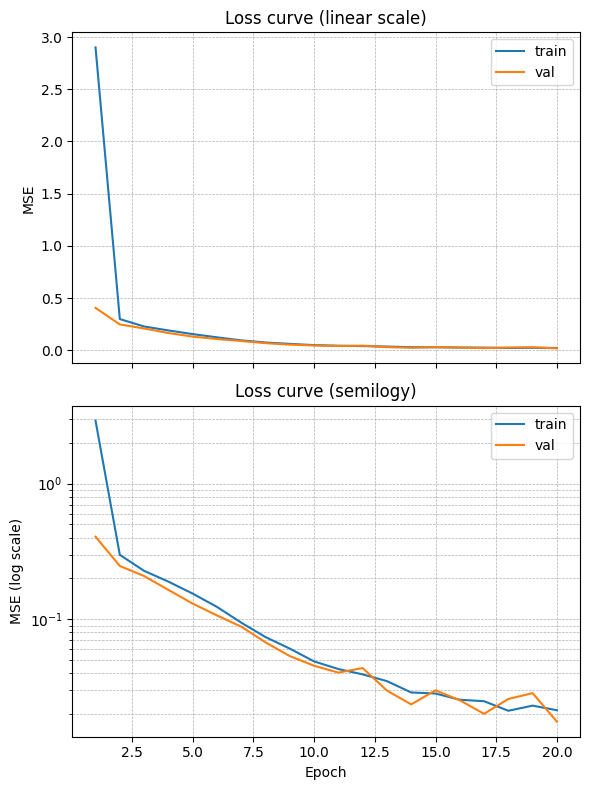

In [104]:
# Define our model
history = model.fit(train_ds.batch(BATCH_SIZE),
                    validation_data=val_ds.batch(BATCH_SIZE),
                    epochs=EPOCHS)

plot_loss(history)


Test to see how well performs on 1 data set.

In [105]:
# Simulate one brand-new data set
x_test  = np.random.rand(N_PER_SAMPLE).astype(np.float32)
theta_true = 5.0
y_test  = theta_true * x_test + SIGMA_EPS*np.random.randn(N_PER_SAMPLE).astype(np.float32)
summary_test = make_summary_sx_sy(x_test[None, :], y_test[None, :])  # shape (1,3)

theta_pred  = model.predict(summary_test)[0,0]
print(f"True θ = {theta_true:.2f},  Predicted θ = {theta_pred:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
True θ = 5.00,  Predicted θ = 4.83


Simulate a couple and find relative error

In [106]:
def average_relative_error(model, num_tests=10000, method="sxsy"):
    """
    Simulate `num_tests` new (x, y) samples, predict θ with the trained model,
    and return the mean relative error over the batch.
    """
    # Simulate a batch
    summaries, theta_true = simulate_batch(num_tests, method=method)        # (num_tests, 3) and (num_tests, 1)

    # Model prediction → shape (num_tests, 1)
    theta_pred = model.predict(summaries, verbose=0)

    # Relative error: |pred - true| / true   (add tiny eps to avoid div-by-0)
    eps       = 1e-8
    rel_error = np.abs(theta_pred.squeeze() - theta_true.numpy().squeeze()) / (theta_true.numpy().squeeze() + eps)

    # Return the mean error
    return rel_error.mean()

avg_re = average_relative_error(model, num_tests=1_000_000, method="sxsy")
print(f"Average relative error over 10000 tests: {avg_re:.4f}")


Average relative error over 10000 tests: 0.1228


### Using the other summary statistics

We first need to regenerate the new dataset and then will proceed as before instantiating a new model.

In [98]:
train_ds_covar = make_dataset(int(N_EXAMPLES*0.9),method="covar")
val_ds_covar   = make_dataset(int(N_EXAMPLES*0.1), method="covar")

In [107]:
model_covar = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(5,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)               # θ̂
])
model_covar.compile(optimizer='adam', loss='mse')
model_covar.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_51 (Dense)                │ (None, 32)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,281 (5.00 KB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 0 (0.00 B)

Fit the model with the new dataset

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 27.5230 - val_loss: 0.2044
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - loss: 0.1974 - val_loss: 0.0933
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step - loss: 0.0873 - val_loss: 0.0763
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step - loss: 0.0743 - val_loss: 0.0773
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step - loss: 0.0768 - val_loss: 0.0718
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step - loss: 0.0763 - val_loss: 0.0720
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step - loss: 0.0772 - val_loss: 0.0674
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step - loss: 0.0758 - val_loss: 0.0690
Epoch 9/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 603us/step - loss: 0.0723 - val_loss: 0.0719
Epoch 10/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step - loss: 0.0678 - val_loss: 0.0645
Epoch 11/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step - loss: 0.0663 - val_loss: 0.0681
Epoch 12/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step 

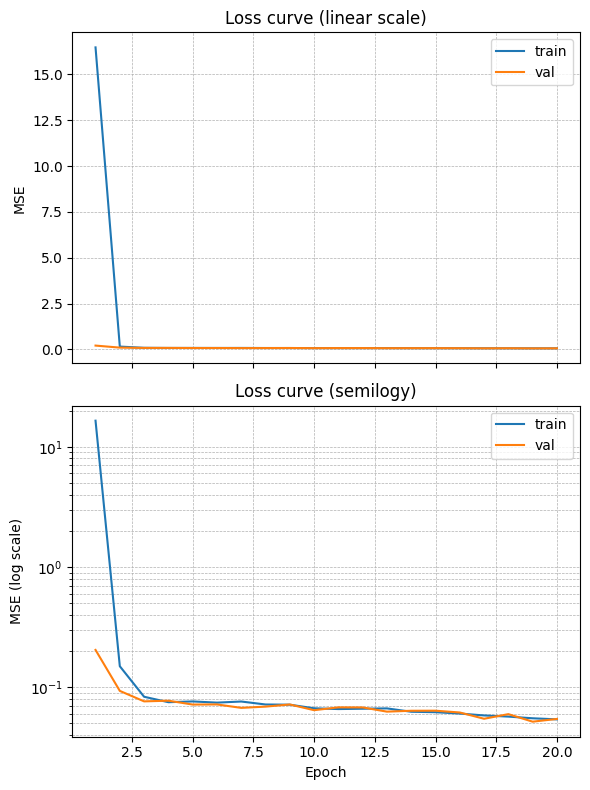

In [108]:
# Define our model
history_covar = model_covar.fit(train_ds_covar.batch(BATCH_SIZE),
                    validation_data=val_ds_covar.batch(BATCH_SIZE),
                    epochs=EPOCHS)

plot_loss(history_covar)


Test to see how well performs on the same dataset as before

In [91]:
# Simulate one brand-new data set
x_test  = np.random.rand(N_PER_SAMPLE).astype(np.float32)
theta_true = 5.0
y_test  = theta_true * x_test + SIGMA_EPS*np.random.randn(N_PER_SAMPLE).astype(np.float32)
summary_test_covar = make_summary_covar(x_test[None, :], y_test[None, :])  # shape (1,5)

theta_pred  = model_covar.predict(summary_test_covar)[0,0]
print(f"True θ = {theta_true:.2f},  Predicted θ = {theta_pred:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
True θ = 5.00,  Predicted θ = 4.90


Now test the average loss on a (different) dataset but as before

In [92]:
avg_re_covar = average_relative_error(model_covar, num_tests=1_000_000, method="covar")
print(f"Average relative error over 1 000 000 tests: {avg_re_covar:.4f}")

Average relative error over 1 000 000 tests: 0.1325


### Results

We see that after 1 million tests for both the error is fairly similar for both. Perhaps slightly better for sxsy method. Both training loss curves look pretty similar